<h1>TP 4 AI52 : Algorithme généritque quantique</h1>


<h2>Importations</h2>

In [2]:
import numpy as np
from copy import copy
import time
import matplotlib.pyplot as plt

<h2>Définition du problème</h2>

On définit la classe BackpackProblem, dont une instance représente une instance du problème générée aléatoirement avec les paramètres fournis.

In [3]:
class BackpackProblem():
    def __init__(self,capacity,number_of_objects,min_weight,max_weight,min_value,max_value) -> None:
        self.capacity = capacity
        self.number_of_objects = number_of_objects
        self.min_weight = min_weight
        self.max_weight = max_weight
        self.min_value = min_value
        self.max_value = max_value

        self.item_values = [0]*number_of_objects
        self.item_weights = [0]*number_of_objects

        self.generate()

    def generate(self): #Génère les poids et valeurs des objets tels que la somme des poids est supérieure au triple de la capacité
        while sum(self.item_weights) < 3*self.capacity:
            for i in range(self.number_of_objects):
                self.item_values[i] = np.random.randint(self.min_value,self.max_value)
                self.item_weights[i] = np.random.randint(self.min_weight,self.max_weight)

    def printProblem(self):
        print("Liste des objets disponibles : ")
        for i in range(self.number_of_objects):
            print("Objet n°",i,", poids =",self.item_weights[i],", valeur =",self.item_values[i])

    def printSolution(self,solution):
        if len(solution) != self.number_of_objects:
            print("ERROR IN SOLUTION")
            exit(0)
        print("Objets du sac à dos : ")
        for i in range(self.number_of_objects):
            if solution[i] == 1:
                print("Objet n°",i)

        total_value = 0
        total_weight = 0

        for i in range(self.number_of_objects) :
            total_value += solution[i]*self.item_values[i]
            total_weight += solution[i]*self.item_weights[i]

        print("Valeur totale : ",total_value)
        print("Poids total : ",total_weight)
        print("Fitness : ",self.fitness(solution))
        

    
    def fitness(self,solution): #Calcule la fitness de la solution passée en paramètre sous la forme d'un tableau de booléens
        if len(solution) != self.number_of_objects:
            print("ERROR IN SOLUTION")
            exit(0)
        total_value = 0
        total_weight = 0

        for i in range(self.number_of_objects) :
            total_value += solution[i]*self.item_values[i]
            total_weight += solution[i]*self.item_weights[i]

        if total_weight <= self.capacity:
            return total_value
        
        return self.capacity - total_weight
    



<h2>Algorithme génétique</h2>

On programme maintenant une fonction implémentant un algorithme génétique classique sur le problème passé en paramètre

In [4]:

def geneticAlgorithm(problem: BackpackProblem,population_size,generations):
    population = []
    for _ in range(population_size):
        chromosome = []
        for _ in range(problem.number_of_objects):
            chromosome.append(np.random.randint(0,2))
        population.append(chromosome)
    
    for _ in  range(generations):

        for i in range(population_size):
            population.append(mutate(population[i]))
            population.append(uniformRandomCrossover(population[i],population[(i+1)%population_size]))
        population.sort(key=lambda x: problem.fitness(x),reverse=True)

        population = population[:population_size]
    
    return population[0]

def mutate(chromosome):
    child = copy(chromosome)
    mutation_count = np.random.randint(1,4)
    for _ in range(mutation_count):
        mutation_target = np.random.randint(0,len(child))
        child[mutation_target] = 1-child[mutation_target]
    return child

def uniformRandomCrossover(chr1,chr2):
    return [np.random.choice(i) for i in zip(chr1,chr2)]

<h2>Algorithme quantique</h2>

On écrit tout d'abord une classe Qubit qui décrit le comportement des qubits :

In [5]:
class Qubit():
    def __init__(self,angle = np.pi/4) -> None:
        self.alpha = np.cos(angle)
        self.beta = np.sin(angle)

    def collapse(self): # Retourne le résultat de l'observation du qubit
        if np.random.random() < pow(self.alpha,2):
            return 0
        return 1
    
    def UGate(self,angle): # Retourne le résultat du passage du qubit dans une porte U dont l'angle correspond au paramètre d'entrée
        new = copy(self)
        newAlpha = self.alpha*np.cos(angle) + self.beta*np.sin(angle)
        newBeta = -self.alpha*np.sin(angle) + self.beta*np.cos(angle)
        new.alpha, new.beta = newAlpha,newBeta
        return new
      


On écrit maintenant une fonction qui retourne un angle de rotation conformément à la politique décrite dans l'énoncé du TP :

In [6]:
def rotationAngle(x: bool, b: bool, better_fitness: bool, signe_a: int, signe_b: int):
    if not x and (not b or (b and not better_fitness)):
        delta_y = 0
        s = 0
    elif b and (x != better_fitness):
        delta_y = 0.05*np.pi
        if signe_a*signe_b != 0:
            if better_fitness:
                s = signe_a*signe_b
            else:
                s = -signe_a*signe_b
        else:
            if better_fitness:
                if signe_a == 0:
                    s = signe_b
                else:
                    s = 0
            else:
                if signe_b == 0:
                    s = signe_a
                else:
                    s = 0
    elif x and better_fitness:
        delta_y = 0.025*np.pi
        if signe_a*signe_b != 0:
            if b:
                s = -signe_a*signe_b
            else:
                s = signe_a*signe_b
        else:
            if not b:
                if signe_a == 0:
                    s = signe_b
                else:
                    s = 0
            else:
                if signe_b == 0:
                    s = signe_a
                else:
                    s = 0
    else:
        delta_y = 0.01*np.pi
        if signe_a*signe_b != 0:
            s = signe_a*signe_b
        else:
            if signe_b == 0:
                    s = signe_a
            else:
                s = 0

    return delta_y*s
    

     


Enfin, on écrit la fonction qui implémente l'algorithme quantique tel que décrit dans l'énoncé :

In [7]:


def quanticAlgorithm(problem : BackpackProblem, population_size = 10, generations = 10):
    quantum_population = []
    for _ in range(population_size):
        quantum_chromosome = []
        for _ in range(problem.number_of_objects):
            quantum_chromosome.append(Qubit(np.pi/4))
        quantum_population.append(quantum_chromosome)
    
    collapsed_population = []
    for quantum_chromosome in quantum_population:
        collapsed_chromosome = []
        for qubit in quantum_chromosome:
            collapsed_chromosome.append(qubit.collapse())
        collapsed_population.append(collapsed_chromosome)
    
    collapsed_population.sort(key=lambda x: problem.fitness(x),reverse=True)

    best = collapsed_population[0]

    for t in range(generations) :
        for j in range(population_size):
            for i in range(problem.number_of_objects):
                angle = rotationAngle(
                    collapsed_population[j][i],
                    best[i],
                    problem.fitness(collapsed_population[j]) >= problem.fitness(best),
                    np.sign(quantum_population[j][i].alpha),
                    np.sign(quantum_population[j][i].beta)
                )
                quantum_population[j][i] = quantum_population[j][i].UGate(angle)
        
        collapsed_population = []
        for quantum_chromosome in quantum_population:
            collapsed_chromosome = []
            for qubit in quantum_chromosome:
                collapsed_chromosome.append(qubit.collapse())
            collapsed_population.append(collapsed_chromosome)
        
        collapsed_population.sort(key=lambda x: problem.fitness(x),reverse=True)

        best = collapsed_population[0]
    
    return best
    

<h2>Comparaison sur différentes instances :</h2>

On écrit maintenant un script qui va générer plusieurs instances du problème en faisant varier le nombre d'objets, et qui va tester les performances de chaque algorithme pour différents nombres de générations sur chaque instance.

On stocke dans resultats un dictionnaire des fitness et temps d'exécution de chaque algorithme pour chaque itération.

In [10]:
NOMBRE_INSTANCES_PROBLEME = 1
CAPACITY = [30 for _ in range(NOMBRE_INSTANCES_PROBLEME)]
OBJECT_COUNT = [17 for i in range(NOMBRE_INSTANCES_PROBLEME)]
MIN_VALUE = [50 for _ in range(NOMBRE_INSTANCES_PROBLEME)]
MAX_VALUE = [350 for _ in range(NOMBRE_INSTANCES_PROBLEME)]
MIN_WEIGHT = [1 for _ in range(NOMBRE_INSTANCES_PROBLEME)]
MAX_WEIGHT = [15 for _ in range(NOMBRE_INSTANCES_PROBLEME)]


NOMBRE_INSTANCES_ALGORITHMES = 2
GENETIC_POP_SIZE = [30 for _ in range(NOMBRE_INSTANCES_ALGORITHMES)]
GENETIC_GENERATIONS = [2000 for i in range(NOMBRE_INSTANCES_ALGORITHMES)]

QUANTUM_POP_SIZE = [30 for _ in range(NOMBRE_INSTANCES_ALGORITHMES)]
QUANTUM_GENERATIONS = [2000 for i in range(NOMBRE_INSTANCES_ALGORITHMES)]


resultats = []

for i in range(NOMBRE_INSTANCES_PROBLEME):
    elites = []
    problem = BackpackProblem(CAPACITY[i],OBJECT_COUNT[i],MIN_WEIGHT[i],MAX_WEIGHT[i],MIN_VALUE[i],MAX_VALUE[i])
    for j in range(NOMBRE_INSTANCES_ALGORITHMES):
        start = time.time()
        solution_genetique = geneticAlgorithm(problem,GENETIC_POP_SIZE[j],GENETIC_GENERATIONS[j])
        genetic_end = time.time()
        genetic_time = genetic_end-start
        solution_quantique = quanticAlgorithm(problem,QUANTUM_POP_SIZE[j],QUANTUM_GENERATIONS[j])
        quantic_time = time.time()-genetic_end
        iteration_result = {
            "genetic_time":genetic_time,
            "quantic_time":quantic_time,
            "genetic_fitness":problem.fitness(solution_genetique),
            "quantic_fitness":problem.fitness(solution_quantique)
        }
        elites.append(iteration_result)
    resultats.append(elites)

    

On trace enfin le temps d'exécution et la fitness en fonction du nombre de générations, et ce pour chaque instance du problème :

ITER  [{'genetic_time': 6.461596727371216, 'quantic_time': 10.955928564071655, 'genetic_fitness': 1430, 'quantic_fitness': -23}, {'genetic_time': 6.3519606590271, 'quantic_time': 11.245248556137085, 'genetic_fitness': 1430, 'quantic_fitness': -34}]


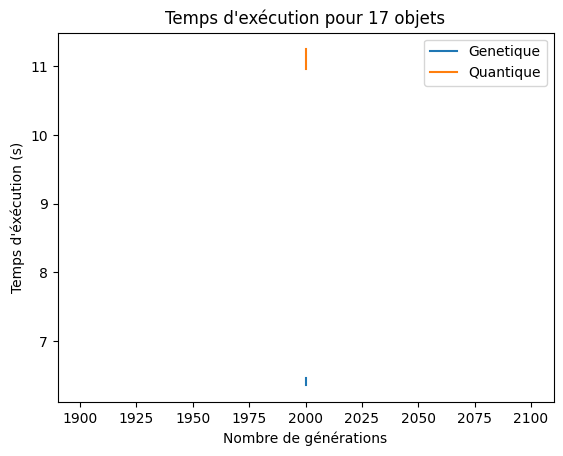

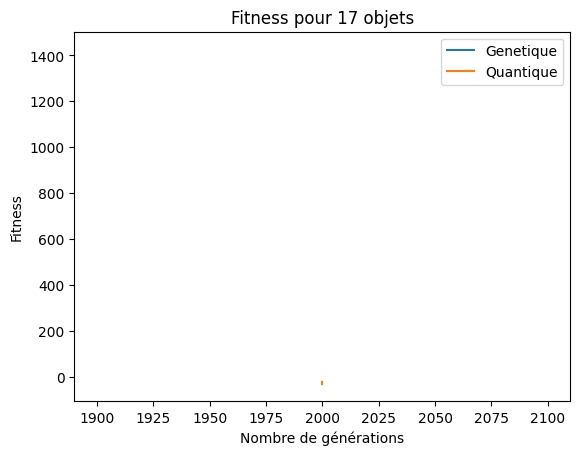

In [12]:
i = -1
for iteration in resultats:
    i+=1
    print("ITER ",iteration)
    fitness_quantique = [iter_result["quantic_fitness"] for iter_result in iteration]
    fitness_genetique = [iter_result["genetic_fitness"] for iter_result in iteration]
    temps_quantique = [iter_result["quantic_time"] for iter_result in iteration]
    temps_genetique = [iter_result["genetic_time"] for iter_result in iteration]
    plt.figure()
    title = "Temps d'exécution pour "+str(OBJECT_COUNT[i])+" objets"
    plt.title(title)
    plt.xlabel("Nombre de générations")
    plt.ylabel("Temps d'éxécution (s)")
    plt.plot(GENETIC_GENERATIONS,temps_genetique,label="Genetique")
    plt.plot(GENETIC_GENERATIONS,temps_quantique,label="Quantique")
    plt.legend()

    plt.figure()
    title = "Fitness pour "+str(OBJECT_COUNT[i])+" objets"
    plt.title(title)
    plt.xlabel("Nombre de générations")
    plt.ylabel("Fitness")
    plt.plot(GENETIC_GENERATIONS,fitness_genetique,label="Genetique")
    plt.plot(GENETIC_GENERATIONS,fitness_quantique,label="Quantique")
    plt.legend()


On constate que l'algorithme génétique est légèrement plus rapide que l'algorithme quantique, et qu'il atteint des solutions à la fois bien meilleures et bien plus stables que celles de l'algorithme quantique